In [29]:
from SOH_func import *
import matplotlib.pyplot as pl
from tensorflow import summary as sm
from tensorflow import keras
from keras import models, layers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import datetime

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [30]:
VERSION = 'Current'
FILE_00 = 'CYCLE_CSV_data.csv'
FILE_01 = 'CYCLE_CSV_data01.csv'
FILE_02 = 'CYCLE_CSV_data02.csv'
# drop_labels = ['시험_시간(s)', '사이클_번호', '사이클_시간(s)', '단계_번호', '단계_시간(s)', '인덱스', '보조전압1(V)', '보조전압2(V)', '보조전압3(V)', '온도(\'C)', '누적_용량(Ah)', '전류_범위', 'OCP(V)', '파워(W)', '부하(Ohm)']
drop_labels_x = ['인덱스', '사이클_번호', '충전_용량(Ah)', '누적_용량(Ah)', '충전_에너지(Wh)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '단위_충전_용량(Ah/g)', '방전_최종전압(V)', '단위_방전_용량(Ah/g)']
drop_labels_y = ['인덱스', '사이클_번호', '충전_용량(Ah)', '누적_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '방전_최종전압(V)', '단위_충전_용량(Ah/g)', '방전_최종전압(V)', '단위_방전_용량(Ah/g)']

Index(['방전_용량(Ah)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
Index(['방전_용량(Ah)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
Index(['방전_용량(Ah)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data00 = (510, 2)


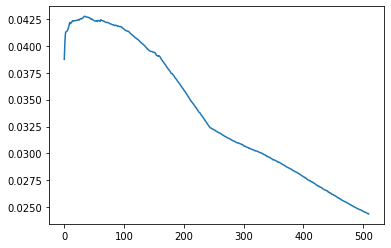

data01 = (480, 2)


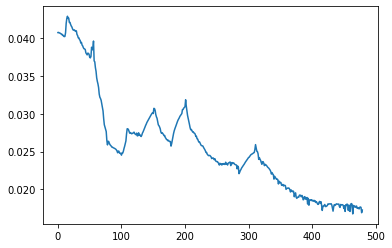

data_test = (480, 2)


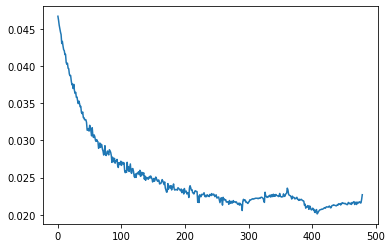

In [31]:
data00, data_cap00 = get_data(FILE_00, drop_labels_x, drop_labels_y)
data01, data_cap01 = get_data(FILE_01, drop_labels_x, drop_labels_y)
data_test, data_cap_test = get_data(FILE_02, drop_labels_x, drop_labels_y)
data01 = data01[70:]
data_cap01 = data_cap01[70:]
data_test = data_test[70:]
data_cap_test = data_cap_test[70:]
print(f'data00 = {data00.shape}')
pl.plot(data_cap00)
pl.show()
print(f'data01 = {data01.shape}')
pl.plot(data_cap01)
pl.show()
print(f'data_test = {data_test.shape}')
pl.plot(data_cap_test)
pl.show()

In [32]:
param = {'seq_len' : 25, 'num_units' : 64, 'num_filters' : 64, 'window' : 3, 'num_epochs' : 2000}
x_train00, y_train00, num_batch00  = seq_gen(data00, data_cap00, param['seq_len'])
x_train01, y_train01, num_batch01  = seq_gen(data01, data_cap01, param['seq_len'])
x_test, y_test, num_batch_test  = seq_gen(data_test, data_cap_test, param['seq_len'])
print(x_train00.shape)

num_batch = 20
x = (20, 25, 2)
y = (20, 25, 1)
num_batch = 19
x = (19, 25, 2)
y = (19, 25, 1)
num_batch = 19
x = (19, 25, 2)
y = (19, 25, 1)
(20, 25, 2)


In [33]:
model = models.Sequential()
model.add(layers.Conv1D(param['num_filters'], param['window'], padding='causal', input_shape = (None, x_train00.shape[-1])))
model.add(layers.LSTM(param['num_units'], return_sequences = True))
model.add(layers.TimeDistributed(layers.Dense(1)))
model.compile(loss = 'mse', optimizer = 'Adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 1)           7         
                                                                 
 lstm_3 (LSTM)               (None, None, 64)          16896     
                                                                 
 time_distributed_3 (TimeDis  (None, None, 1)          65        
 tributed)                                                       
                                                                 
Total params: 16,968
Trainable params: 16,968
Non-trainable params: 0
_________________________________________________________________


In [34]:
epoch_index = param['num_epochs'] * 2
loss_dict = {}
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + f'{param["num_filters"]}FL-{param["num_units"]}UN-{epoch_index}EP-{param["seq_len"]}SQ'
file_path = f'Checkpoints\SOH_{VERSION}_Checkpoint\{param["num_filters"]}FL-{param["num_units"]}UN-{epoch_index}EP-{param["seq_len"]}SQ\{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.h5'
hist_freq = 80

In [35]:
callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                 TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
fitdata = model.fit(x_train00, y_train00, epochs=param['num_epochs'], verbose = 2, validation_split = 0.3, callbacks=callback_list)

Epoch 1/2000
1/1 - 1s - loss: 0.0016 - val_loss: 3.8173e-04 - 1s/epoch - 1s/step
Epoch 2/2000
1/1 - 0s - loss: 9.2079e-04 - val_loss: 1.0851e-04 - 38ms/epoch - 38ms/step
Epoch 3/2000
1/1 - 0s - loss: 4.3748e-04 - val_loss: 3.3523e-05 - 41ms/epoch - 41ms/step
Epoch 4/2000
1/1 - 0s - loss: 1.5888e-04 - val_loss: 1.5217e-04 - 24ms/epoch - 24ms/step
Epoch 5/2000
1/1 - 0s - loss: 8.4618e-05 - val_loss: 4.0040e-04 - 21ms/epoch - 21ms/step
Epoch 6/2000
1/1 - 0s - loss: 1.7263e-04 - val_loss: 6.1203e-04 - 23ms/epoch - 23ms/step
Epoch 7/2000
1/1 - 0s - loss: 2.8896e-04 - val_loss: 6.8929e-04 - 24ms/epoch - 24ms/step
Epoch 8/2000
1/1 - 0s - loss: 3.3427e-04 - val_loss: 6.4455e-04 - 22ms/epoch - 22ms/step
Epoch 9/2000
1/1 - 0s - loss: 3.0374e-04 - val_loss: 5.3007e-04 - 23ms/epoch - 23ms/step
Epoch 10/2000
1/1 - 0s - loss: 2.3270e-04 - val_loss: 3.9497e-04 - 22ms/epoch - 22ms/step
Epoch 11/2000
1/1 - 0s - loss: 1.5683e-04 - val_loss: 2.7113e-04 - 23ms/epoch - 23ms/step
Epoch 12/2000
1/1 - 0s - lo

In [36]:
epoch_index += param['num_epochs']
callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                 TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
fitdata = model.fit(x_train01, y_train01, epochs=param['num_epochs'], verbose = 2, validation_split = 0.3, callbacks=callback_list)

Epoch 1/2000
1/1 - 0s - loss: 1.5665e-05 - val_loss: 5.5983e-05 - 81ms/epoch - 81ms/step
Epoch 2/2000
1/1 - 0s - loss: 2.2722e-05 - val_loss: 2.9242e-05 - 42ms/epoch - 42ms/step
Epoch 3/2000
1/1 - 0s - loss: 8.5764e-06 - val_loss: 2.5289e-05 - 37ms/epoch - 37ms/step
Epoch 4/2000
1/1 - 0s - loss: 1.8452e-05 - val_loss: 2.2039e-05 - 38ms/epoch - 38ms/step
Epoch 5/2000
1/1 - 0s - loss: 6.8165e-06 - val_loss: 3.5096e-05 - 24ms/epoch - 24ms/step
Epoch 6/2000
1/1 - 0s - loss: 1.4661e-05 - val_loss: 1.9337e-05 - 38ms/epoch - 38ms/step
Epoch 7/2000
1/1 - 0s - loss: 5.9781e-06 - val_loss: 1.9027e-05 - 38ms/epoch - 38ms/step
Epoch 8/2000
1/1 - 0s - loss: 1.1405e-05 - val_loss: 1.5186e-05 - 40ms/epoch - 40ms/step
Epoch 9/2000
1/1 - 0s - loss: 6.2138e-06 - val_loss: 1.7956e-05 - 25ms/epoch - 25ms/step
Epoch 10/2000
1/1 - 0s - loss: 8.2187e-06 - val_loss: 1.5378e-05 - 25ms/epoch - 25ms/step
Epoch 11/2000
1/1 - 0s - loss: 7.1433e-06 - val_loss: 1.3382e-05 - 44ms/epoch - 44ms/step
Epoch 12/2000
1/1 -

1/1 [==============================] - 0s 194ms/step
(475, 1) (475, 1)
1FL-64UN-6000EP-25SQ


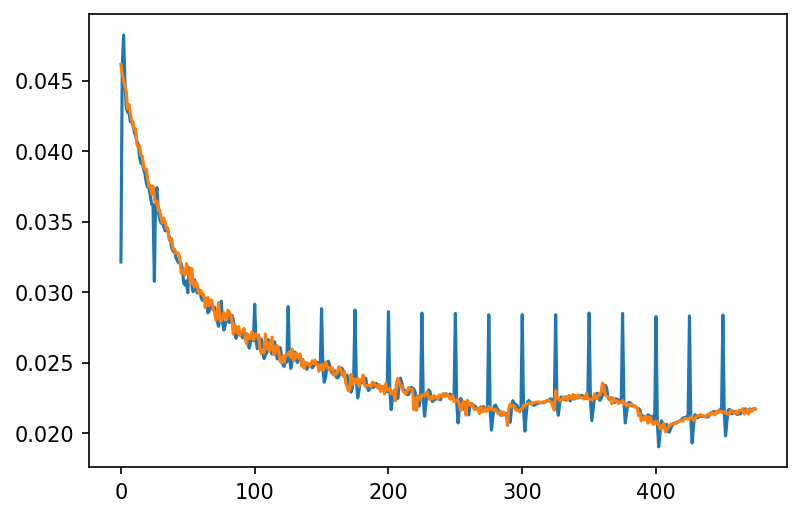

In [37]:
show_and_prove(model, VERSION, file_path, epoch_index, x_test, y_test, loss_dict, param)